<a href="https://colab.research.google.com/github/dmitr2ish/MOMO_2023/blob/main/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_sklearn_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цель Блокнота

Решение задачи регрессии в scikit-learn с помощью линейной модели - линейная регрессия
* Обучение класса `SGDRegressor` и анализ атрибутов
* Анализ модели для разных данных
* Предобразование целевой переменной с помощью класса `TransformedTargetRegressor`
* Сохранение модели

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных


Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка из [предыдущего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно


In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [ ]:
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year,])

# Линейная Регрессия

In [ ]:
from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тестовую и тренировочную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
X_train

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission
2215,BMW,X5,2010,Universal,150000.0,3000.0,Petrol,Automatic
24043,Renault,Kangoo,2004,Minivan,198500.0,1499.0,Diesel,Manual
25744,Volkswagen,Phaeton,2007,Sedan,240000.0,300.0,Diesel,Automatic
16217,Skoda,Kodiaq,2018,SUV,24000.0,2000.0,Petrol,Automatic
8019,Mercedes,E Class,2014,Sedan,173000.0,2148.0,Diesel,Automatic
...,...,...,...,...,...,...,...,...
29802,Opel,Astra,2012,Universal,180000.0,1300.0,Diesel,Manual
5390,Skoda,Octavia,2006,Universal,250000.0,1900.0,Diesel,Manual
860,Toyota,Auris,2015,Hatchback,179713.0,1400.0,Diesel,Manual
15795,Dacia,Logan,2006,Sedan,300000.0,1396.0,Metan/Propan,Manual


# Оценим модель с использованием только числовых данных

**Преобразуем данные**

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса
* "Обучаем" через `.fit`

In [ ]:
model = SGDRegressor(random_state = 42)

model.fit(X_train_prep, y_train);

## Подготовим несколько функций для анализа обученной модели

**вытаскивание коэффициентов из модели**

In [ ]:
def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_[0]
    B=model.coef_
    return B0, B

**написание модели**

In [ ]:
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

**визуализации весов в виде столбчатых диаграмм**

In [ ]:
def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов
    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

### Напишем уравнение модели

In [ ]:
B0, B = get_coefs(model)
features_names = list(columns_num)
print_model(B0,B,features_names)

Решение
9014.373-874.50*Distance+2984.62*Engine_capacity(cm3)+4807.24*Year


### Визуализируем веса в виде столбчатых диаграмм

In [ ]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score, **kwargs):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, **kwargs)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.5419
r2 на валидационной выборке: 0.5379
mse на тренировочной выборке: 27853457.5427
mse на валидационной выборке: 29091958.0937
rmse на тренировочной выборке: 5277.6375
rmse на валидационной выборке: 5393.6961


## Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.050574,0.002971,0.545649,-2.690292e+07,-3539.678476,-37681.515095
1,0.038254,0.001736,0.556572,-2.867041e+07,-3629.150133,-42203.529250
2,0.046553,0.001677,0.552150,-2.749462e+07,-3506.567818,-39917.892950
3,0.021224,0.001658,0.518209,-2.877513e+07,-3618.395237,-29616.446143
4,0.036234,0.001728,0.531088,-2.746163e+07,-3448.223397,-42112.667418




test_R2      5.407338e-01
test_-MSE   -2.786094e+07
test_-MAE   -3.548403e+03
test_-Max   -3.830641e+04
dtype: float64


## Визуализация ошибок от scikit-learn

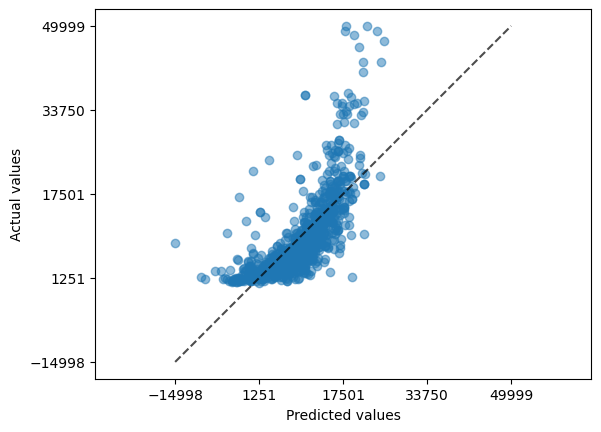

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* используя только 3 числовых признака можно с достаточно большой погрешностью предсказывать цены

* есть проблемы предсказания как низких значений цен, так и высоких

* модель выглядит "логично": рост года выпуска и объем двигателя положительно сказывается на цене, рост пробега - отрицательно



## Объединяем Pipeline Предобработки и Модель

Синтаксис - тот же
Список из
* имен
* объектов

In [ ]:
pipe_num = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', SGDRegressor(random_state = 42))
])

Чтобы "обратиться" к части Pipeline - достаточно помнить "имя"

In [ ]:
pipe_num['preprocessors']

ColumnTransformer(transformers=[('num_distance',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['Distance']),
                                ('num_engine',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Engine_capacity(cm3)']),
                                ('num_year',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['Year'])])

In [ ]:
pipe_num['model']

SGDRegressor(random_state=42)

Так же обучаем через `.fit()`

In [ ]:
pipe_num.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model', SGDRegressor(random_state=42))])

In [ ]:
B0, B = get_coefs(pipe_num['model'])
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
9014.373-874.50*Distance+2984.62*Engine_capacity(cm3)+4807.24*Year


In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.5419
r2 на валидационной выборке: 0.5379
mse на тренировочной выборке: 27853457.5427
mse на валидационной выборке: 29091958.0937
rmse на тренировочной выборке: 5277.6375
rmse на валидационной выборке: 5393.6961


In [ ]:
cross_validation (X_train, y_train,
                  pipe_num,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.123603,0.009439,0.545952,-2.688503e+07,-3542.960738,-37684.488178
1,0.110987,0.009435,0.556581,-2.866982e+07,-3629.013665,-42209.556514
2,0.128146,0.009544,0.555547,-2.728605e+07,-3507.779068,-39915.551392
3,0.128439,0.013906,0.518215,-2.877477e+07,-3618.228316,-29615.840045
4,0.159362,0.013647,0.531079,-2.746213e+07,-3448.365506,-42114.191910




test_R2      5.414750e-01
test_-MSE   -2.781556e+07
test_-MAE   -3.549269e+03
test_-Max   -3.830793e+04
dtype: float64


# Оценим влияние предварительной обработки целевой переменной


Мы забыли поправить целевую метку - она же была не нормальная (в смысле нормального распределения)

И решение - `TransformedTargetRegressor`

In [ ]:
from sklearn.compose import TransformedTargetRegressor

In [ ]:
pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [ ]:
B0, B = get_coefs(pipe_num_transform['model'].regressor_)
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
-0.003-0.03*Distance+0.34*Engine_capacity(cm3)+0.77*Year


In [ ]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.6350
r2 на валидационной выборке: 0.6320
mse на тренировочной выборке: 22194996.0305
mse на валидационной выборке: 23166227.2505
rmse на тренировочной выборке: 4711.1565
rmse на валидационной выборке: 4813.1307


In [ ]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.217831,0.015871,0.648332,-2.082287e+07,-2722.564983,-38575.837002
1,0.173558,0.016452,0.660928,-2.192316e+07,-2779.283250,-38783.589818
2,0.183610,0.013923,0.651674,-2.138462e+07,-2741.044103,-39739.329232
3,0.170537,0.018436,0.634608,-2.182320e+07,-2807.242628,-30102.066990
4,0.176194,0.013769,0.636800,-2.127066e+07,-2694.874840,-42248.084176




test_R2      6.464682e-01
test_-MSE   -2.144490e+07
test_-MAE   -2.749002e+03
test_-Max   -3.788978e+04
dtype: float64


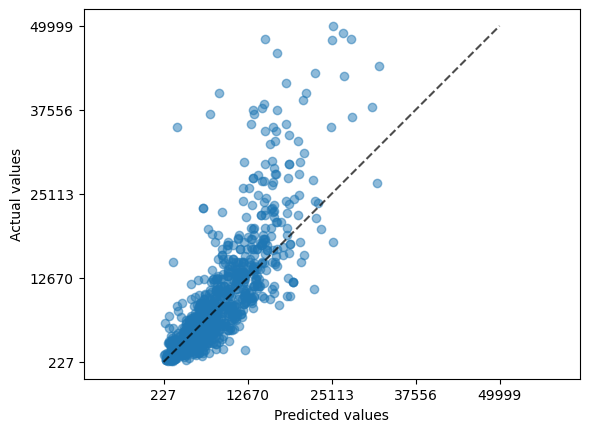

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* предварительная обработка целевой переменной улучшает результаты линейной модели (метрика r2 на кроссвалидации `0.63` против `0.54`)

* в целом предварительная обработка целевой переменной улучшила предсказание низких значений цен (с большими ценами всё ещё проблемы)

* модель всё ещё выглядит "логично": рост года выпуска и объем двигателя положительно сказывается на цене, рост пробега - отрицательно, однако нужно помнить что в этом случае связь - не линейная

# Оценим влияние категориальных признаков

In [ ]:
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
pipe_all_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('ca...
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make']),
                                                 ('cat_model',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Model'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [ ]:
cat_style_fuel_names = pipe_all_transform['preprocessors'].transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)
cat_make_names =  pipe_all_transform['preprocessors'].transformers_[5][1]['encoder'].get_feature_names_out(cat_make)
cat_model_names =  pipe_all_transform['preprocessors'].transformers_[6][1]['encoder'].get_feature_names_out(cat_model)

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year,
                    cat_transmission,
                    cat_style_fuel_names,
                    cat_make_names,
                    cat_model_names])

In [ ]:
B0, B = get_coefs(pipe_all_transform['model'].regressor_)
features_names = list(columns)

print_model (B0,B,features_names)

Решение
0.124-0.02*Distance+0.13*Engine_capacity(cm3)+0.69*Year-0.22*Transmission+0.05*Style_Cabriolet-0.14*Style_Combi-0.04*Style_Coupe+0.27*Style_Crossover-0.19*Style_Hatchback-0.03*Style_Microvan-0.07*Style_Minivan+0.11*Style_Pickup-0.01*Style_Roadster+0.31*Style_SUV-0.05*Style_Sedan-0.10*Style_Universal-0.05*Fuel_type_Diesel+0.25*Fuel_type_Electric-0.04*Fuel_type_Hybrid-0.09*Fuel_type_Metan/Propan-0.09*Fuel_type_Petrol+0.14*Fuel_type_Plug-in Hybrid-0.00*Make_Alfa Romeo+0.31*Make_Audi+0.36*Make_BMW-0.25*Make_Chevrolet-0.05*Make_Chrysler-0.24*Make_Citroen-0.33*Make_Dacia-0.22*Make_Daewoo-0.01*Make_Dodge-0.13*Make_Fiat-0.12*Make_Ford+0.05*Make_Honda-0.06*Make_Hyundai+0.05*Make_Infiniti+0.10*Make_Jaguar-0.03*Make_Jeep-0.08*Make_KIA+0.14*Make_Land Rover+0.34*Make_Lexus+0.03*Make_Lincoln-0.07*Make_Mazda+0.37*Make_Mercedes+0.05*Make_Mini-0.06*Make_Mitsubishi-0.09*Make_Nissan-0.06*Make_Opel+0.19*Make_Other-0.19*Make_Peugeot+0.29*Make_Porsche-0.17*Make_Rare-0.19*Make_Renault-0.10*Make_Rover

**Модификация функции для отрисовки весов**

In [ ]:
def vis_weigths_threshold(weights, feature_names, threshold, width = 1200, height = 600):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask[1:]) if m]

    # Рисуем столбчатую диаграмму
    vis_weigths(weights_filtered,feature_names_filtered, width = width, height = height)

In [ ]:
Bs = np.hstack([B0,B])
vis_weigths_threshold(Bs,columns, 0.08, width = 1800)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.7738
r2 на валидационной выборке: 0.7716
mse на тренировочной выборке: 13752252.8730
mse на валидационной выборке: 14377145.2788
rmse на тренировочной выборке: 3708.4030
rmse на валидационной выборке: 3791.7206


In [ ]:
cross_validation (X_train, y_train,
                  pipe_all_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.812855,0.033974,0.790398,-1.241093e+07,-2017.386741,-30401.612441
1,0.768597,0.033875,0.774743,-1.456428e+07,-2136.713533,-38500.768816
2,0.787949,0.032645,0.776059,-1.374827e+07,-2064.469015,-39306.882803
3,0.780241,0.030441,0.763919,-1.410005e+07,-2135.044564,-28615.533456
4,0.780422,0.032036,0.756182,-1.427912e+07,-2075.618844,-40513.504911




test_R2      7.722601e-01
test_-MSE   -1.382053e+07
test_-MAE   -2.085847e+03
test_-Max   -3.546766e+04
dtype: float64


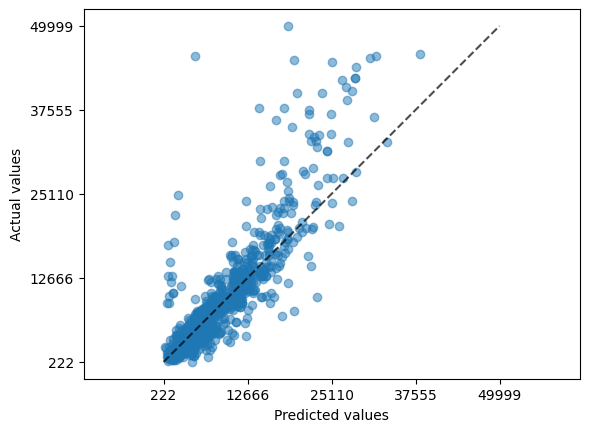

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_all_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* добавление категориальных признаков улучшает результаты линейной модели (метрика r2 на кроссвалидации `0.77` против `0.63`)

* предсказание дорогих автомобилей немного улучшилось

* добавляется интерпритация категориальных признаков: ручная коробка передач негативно влияет на цену, есть типы топлива/модели с положительным и отрицательным вкладом в цену

Какие гипотезы можно еще протестировать:

* как влияет замена редких значений на предсказание модели

* улучшит ли предсказание модели добавление [полиномиальных признаков](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) (для этого можно добавить в pipeline соответсвующий класс библиотеки scikit-learn)

# Про то как Сохранять Модель

In [ ]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [ ]:
dump(model, 'model.joblib')  # чтобы сохранить объект
dump(pipe_num, 'pipe_num.joblib')  # чтобы сохранить объект
dump(pipe_num_transform, 'pipe_num_transform.joblib')  # чтобы сохранить объект
dump(pipe_all_transform, 'pipe_all_transform.joblib')  # чтобы сохранить объект

['pipe_all_transform.joblib']

In [ ]:
pipe_load = load('pipe_all_transform.joblib')  # чтобы загрузить из файла в формате joblib

In [ ]:
pipe_load

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('ca...
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make']),
                                                 ('cat_model',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Model'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [ ]:
cross_validation (X_train, y_train,
                  pipe_load,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.780935,0.033345,0.790398,-1.241093e+07,-2017.386741,-30401.612441
1,0.814131,0.034623,0.774743,-1.456428e+07,-2136.713533,-38500.768816
2,0.791329,0.034408,0.776059,-1.374827e+07,-2064.469015,-39306.882803
3,0.819914,0.054514,0.763919,-1.410005e+07,-2135.044564,-28615.533456
4,1.164356,0.048429,0.756182,-1.427912e+07,-2075.618844,-40513.504911




test_R2      7.722601e-01
test_-MSE   -1.382053e+07
test_-MAE   -2.085847e+03
test_-Max   -3.546766e+04
dtype: float64
